<a href="https://colab.research.google.com/github/GuQiangJS/finance-tools-py/blob/master/jupyters/%E6%8C%87%E6%A0%87%E7%9B%B8%E5%85%B3%E6%80%A7%E6%B5%8B%E8%AF%95_%E8%B6%8B%E5%8A%BF%E6%80%A7%E6%8C%87%E6%A0%87_%E5%B8%83%E6%9E%97%E5%B8%A6_BBANDS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## [初步结论](#scrollTo=yAkJf2a15Rw2&line=3&uniqifier=1)

布林带并不能看出未来趋势。

**当30日布林带上线/下线的值大于 ``2.5``** 时，基本上未来30天，**股价是在下行的**。

> 其他日期值并未过多测试。

## 安装思源字体

这样显示好看点。呵呵！

In [0]:
import os
noto_font_path='/usr/share/fonts/NotoSansCJKsc-Medium.otf'
if not os.path.exists(noto_font_path):
    !wget "https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKsc-hinted.zip"
    !unzip "NotoSansCJKsc-hinted.zip"
    !mv NotoSansCJKsc-Medium.otf /usr/share/fonts/
from IPython.display import clear_output
clear_output(True)

## 安装第三方库。

[talib](https://www.fmz.com/bbs-topic/1234)，[finance-tools-py](https://github.com/GuQiangJS/finance-tools-py)

In [0]:
try:
    import talib
except ModuleNotFoundError:
    !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
    !tar -xzvf ta-lib-0.4.0-src.tar.gz
    %cd ta-lib
    !./configure --prefix=/usr
    !make
    !make install
    !pip install Ta-Lib
    import talib
try:
    import finance_tools_py
    from finance_tools_py.simulation import Simulation
    from finance_tools_py.simulation.callbacks import CallBack
    from finance_tools_py.simulation.callbacks.talib import BBANDS
    from finance_tools_py.simulation.callbacks import Rolling_Future
except ModuleNotFoundError:
    !pip install git+https://github.com/GuQiangJS/finance-tools-py.git -U
    from finance_tools_py.simulation import Simulation
    from finance_tools_py.simulation.callbacks import CallBack
    from finance_tools_py.simulation.callbacks.talib import BBANDS
    from finance_tools_py.simulation.callbacks import Rolling_Future
clear_output(True)

## 其他相关引用

In [0]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
# sns.set()
%matplotlib inline
# plt.rcParams['figure.figsize'] = (18, 6)
plt.style.use('ggplot')
fontprop = matplotlib.font_manager.FontProperties(fname=noto_font_path)
matplotlib.font_manager.fontManager.ttflist += matplotlib.font_manager.createFontList([noto_font_path])
plt.rcParams['font.family'] = fontprop.get_name()

plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题

import warnings
warnings.filterwarnings('ignore')
# %tensorflow_version 2.x
# import tensorflow as tf
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))

## 读取数据

1. 读取交易日期、开盘价、最高价、最低价、收盘价、成交量。所有数据均取**前复权**数据。

In [0]:
def read_data():
    symbol='600036'
    data=pd.read_csv('https://raw.githubusercontent.com/GuQiangJS/temp/master/600036_daily.csv',parse_dates=True,
                    usecols=['date','open_qfq','high_qfq','low_qfq','close_qfq','volume_qfq'])
    data['date']=pd.to_datetime(data['date'])
    data.rename(columns={'open_qfq':'open','high_qfq':'high','low_qfq':'low','close_qfq':'close','volume_qfq':'volume'},inplace=True)
    data['preclose']=data['close'].shift()
    data['nextclose']=data['close'].shift(-1)
    data['nextchange']=data['nextclose']-data['close']
    data['nextchange_sign']=np.sign(data['nextchange'])
    return data

## 布林带说明

1. 当布林线的上、中、下轨线**同时向上运行**时，表明股价强势特征非常明显，股价短期内将继续上涨，投资者应坚决持股待涨或逢低**买入**。

2. 当布林线的上、中、下轨线**同时向下运行**时，表明股价的弱势特征非常明显，股价短期内将继续下跌，投资者应坚决持币观望或逢高**买出**。

3. 当布林线的**上轨线向下**运行，而**中轨线和下轨线却还在向上运行**时，表明股价处于**整理态势**之中。
> 如果股价是处于**长期上升趋势**时，则表明股价是上涨途中的强势整理，投资者可以**持股观望**或逢低短线买入；
> 
> 如果股价是处于**长期下跌趋势**时，则表明股价是下跌途中的弱势整理，投资者应以**持币观望**或逢高减仓为主。

---

1. 当股价前期一直处于**长时间的下跌行情**后开始出现布林线的**三条线横向移动**时，表明股价是处于构筑底部阶段，投资者可以开始**分批少量建仓**。一旦三条线向上发散则可加大买入力度。

2. 当股价前期是处于小幅的上涨行情后开始出现布林线的三条线横向移动，表明股价是处于上升阶段的整理行情，投资者可以持股待涨或逢低短线吸纳，一旦三条线向上发散则可短线加码买入。

3. 当股价刚刚经历一轮大跌行情时开始出现布林线的三条线横向移动，表明股价是处于下跌阶段的整理行情，投资者应以持币观望和逢高减磅为主，一旦三条线向下发散则坚决清仓离场。

## 数据处理

计算n日的布林带数据和未来n日的最大值，最小值，中位数，平均值等数据。

In [0]:
class BBANDS_New(BBANDS):
    def on_preparing_data(self, data, **kwargs):
        super().on_preparing_data(data, **kwargs)
        data['布林带 上线/下线']=data['bbands_{0}_{1}_{2}_up'.format(timeperiod,nbdevup,nbdevdn)]/data['bbands_{0}_{1}_{2}_low'.format(timeperiod,nbdevup,nbdevdn)]

class Rolling_Future_New(Rolling_Future):
    def on_preparing_data(self, data, **kwargs):
        super().on_preparing_data(data, **kwargs)
        data['未来涨跌']=np.sign(data['rolling_{}_{}_mean'.format(self.col_name,self.timeperiod)]-data[self.col_name])
        data.rename(columns={'rolling_close_{}_mean/close'.format(self.timeperiod):'未来 {} 日均价/当前'.format(self.timeperiod)},inplace=True)


## `30日布林带上线/下线` 与 `未来30日均值/收盘价` 之间的关系

从下图的 ``bbands_{0}_{1}_{2}_up/bbands_{0}_{1}_{2}_low`` 列与 ``rolling_{}_mean/close`` 列的关系，可以简单的看出 **当布林带上线/布林带下线的值大于 ``2.5``** 时，基本上 ``rolling_{}_mean/close`` 都是小于1的。也就是说这个条件下未来n天，**股价是在下行的**。

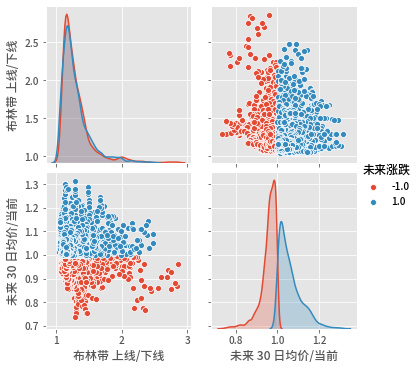

In [0]:
data=read_data()
timeperiod=30
nbdevup=3
nbdevdn=3

s=Simulation(data,'',callbacks=[BBANDS_New(timeperiod,nbdevup,nbdevdn),
                Rolling_Future_New(timeperiod=timeperiod)])
s.simulate()

g=sns.pairplot(s.data[['布林带 上线/下线',
           '未来 {} 日均价/当前'.format(timeperiod),'未来涨跌'
           ]],hue='未来涨跌'
           )

让我们来看一看那部分超过2.5的数据是什么？

刚好在08年那段下跌区间中。

In [0]:
s.data[s.data['布林带 上线/下线'.format(timeperiod,nbdevup,nbdevdn)]>2.5][['date','close',
                                'rolling_close_{}_min'.format(timeperiod),
                                'rolling_close_{}_max'.format(timeperiod),
                                'rolling_close_{}_mean'.format(timeperiod),
                                'rolling_close_{}_med'.format(timeperiod),
                                ]]

,date,close,rolling_close_30_min,rolling_close_30_max,rolling_close_30_mean,rolling_close_30_med
1523,2008-10-07,7.784347,5.567381,7.599599,6.678360,6.813176
1524,2008-10-08,7.135235,5.567381,7.599599,6.670870,6.813176
1525,2008-10-09,7.185167,5.567381,7.599599,6.653394,6.758251
1526,2008-10-10,6.910542,5.567381,7.599599,6.642909,6.718306
1527,2008-10-13,7.599599,5.567381,7.589613,6.598303,6.680857
1528,2008-10-14,7.454798,5.567381,7.589613,6.555362,6.628429
1529,2008-10-15,7.589613,5.567381,7.424839,6.506429,6.546041
1530,2008-10-16,7.155208,5.567381,7.424839,6.473141,6.421212
1531,2008-10-17,7.080310,5.567381,7.424839,6.431531,6.303873


### 当30日布林带上线/30日布林带下线的值大于2时，60%的可能性下跌。

In [0]:
pp=s.data[s.data['布林带 上线/下线'.format(timeperiod,nbdevup,nbdevdn)]>2]
pp['u']=np.sign(pp['rolling_close_{}_mean'.format(timeperiod)]-pp['close'])
pp['u'].value_counts(normalize=True)

-1.0    0.6
 1.0    0.4
Name: u, dtype: float64

## `5日布林带上线/下线` 与 `未来5日均值/收盘价` 之间的关系

从下图的 ``bbands_{0}_{1}_{2}_up/bbands_{0}_{1}_{2}_low`` 列与 ``rolling_{}_mean/close`` 列的关系，可以简单的看出 **当布林带上线/布林带下线的值大于 ``1.5``** 时，基本上 ``rolling_{}_mean/close`` 都是大于1的。也就是说这个条件下未来n天，**股价是在上行的**。（大约65%的上涨比率）

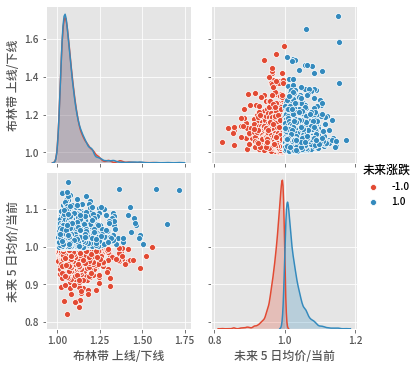

In [0]:
data=read_data()
timeperiod=5
nbdevup=2.5
nbdevdn=2.5

s=Simulation(data,'',callbacks=[BBANDS_New(timeperiod,nbdevup,nbdevdn),
                Rolling_Future_New(timeperiod=timeperiod)])
s.simulate()

g=sns.pairplot(s.data[['布林带 上线/下线'.format(timeperiod,nbdevup,nbdevdn),
            '未来 {} 日均价/当前'.format(timeperiod),
            '未来涨跌'
           ]],hue='未来涨跌')

### 当5日布林带上线/5日布林带下线的值大于1.4时，65%的可能性上涨。

In [0]:
pp=s.data[s.data['布林带 上线/下线'.format(timeperiod,nbdevup,nbdevdn)]>1.4]
pp['u']=np.sign(pp['rolling_close_{}_mean'.format(timeperiod)]-pp['close'])
pp['u'].value_counts(normalize=True)

 1.0    0.65
-1.0    0.35
Name: u, dtype: float64

## 初步结论：上下两个数据的截然相反的结果，印证了通过布林带并不能看出未来趋势。

下图把未来是否上涨的区间拉长到了布林带区间的一倍，也未能看出任何有效趋势。和前面30日布林带数据一致。**当布林带上线/布林带下线的值大于 ``2.5``** 时，基本上 ``rolling_{}_mean/close`` 都是小于1的。也就是说这个条件下未来n天，**股价是在下行的**。

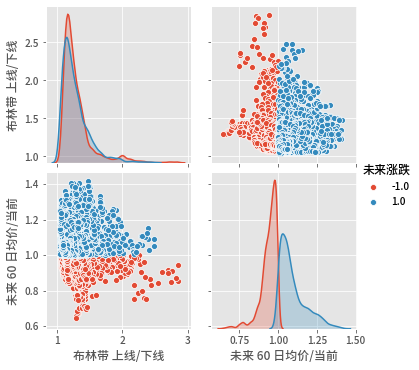

In [0]:
data=read_data()
timeperiod=30
timeperiod_rolling=60
nbdevup=3
nbdevdn=3
s=Simulation(data,'',callbacks=[BBANDS_New(timeperiod,nbdevup,nbdevdn),
                Rolling_Future_New(timeperiod=timeperiod_rolling,skip=timeperiod)])
s.simulate()
g=sns.pairplot(s.data[['布林带 上线/下线'.format(timeperiod,nbdevup,nbdevdn),
            '未来 {} 日均价/当前'.format(timeperiod_rolling),
            '未来涨跌'
            ]],hue='未来涨跌')